In [1]:
sc.uninstall_package('pip')
sc.install_pypi_package("pip==22.2.2")
sc.install_pypi_package("opencv-python")
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1694852846836_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Uninstalling pip-9.0.1:
  Successfully uninstalled pip-9.0.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 29.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 61.6 MB/s eta 0:00:00




[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: /tmp/1694853461341-0/bin/python -m pip install --upgrade pip


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: /tmp/1694853461341-0/bin/python -m pip install --upgrade p

In [13]:
from itertools import product
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, asc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
#Convert latitude, longitude to (x,y) tile coordinate at given zoom.
def deg_to_rad(lat_deg, lon_deg, zoom):
    lat_rad = np.radians(lat_deg)
    z = 2**zoom
    x_tile = int((lon_deg + 180.0) / 360.0 * z)
    y_tile = int((1.0 - np.arcsinh(np.tan(lat_rad)) / np.pi) / 2.0 * z)
    return (x_tile, y_tile)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
#Get height based on rgb colors about regions.
def get_RGB(data):
    (R, G, B) = cv2.split(data)
    height = (R / 256.0 + G + B * 256.0) - 32768.0
    pos_height = np.where(height >= 0, height, 0)
    return pos_height

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
"""
Groups:
0 -> 5% of values
1 -> 5% - 35% of values
2 -> 35% - 60% of values
3 -> 60% - 80% of values
4 -> 80% - 95% of values
5 -> 95% - 100% of values
"""

#Process regions to sort them into indepening groups
def process_regions(input_array, regions):
    new_array = input_array
    
    new_array = np.where(input_array >= regions[0], 0, new_array)
    new_array = np.where((regions[0] > input_array) & (input_array >= regions[1]), 1, new_array)
    new_array = np.where((regions[1] > input_array) & (input_array >= regions[2]), 2, new_array)
    new_array = np.where((regions[2] > input_array) & (input_array >= regions[3]), 3, new_array)
    new_array = np.where((regions[3] > input_array) & (input_array >= regions[4]), 4, new_array)
    new_array = np.where((regions[4] > input_array), 5, new_array)

    return new_array

#Create groups of regions
def create_regions(data, rdd):
    means = rdd.map(lambda x: cv2.mean(x)).sortBy(lambda x: x[0]).collect()
    regions = []

    regions.append(means[int(95*len(means)/100)][0])
    regions.append(means[int(80*len(means)/100)][0])
    regions.append(means[int(60*len(means)/100)][0])
    regions.append(means[int(35*len(means)/100)][0])
    regions.append(means[int(5*len(means)/100)][0])
    
    processed = rdd.map(lambda array: process_regions(array, regions)).collect()
    
    return processed

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
def idx(file):
    out = int(file.split("/")[5])
    return out

def idy(file):
    out = file.split("/")[6]
    out = int(out.split(".")[0])
    return out

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
def main():
    
    AMERICA = (72, -168, -54, -25)
    lat1, lon1, lat2, lon2 = AMERICA
    zoom = 5
    
    lat_min, lon_min = min(lat1, lat2), min(lon1, lon2)
    lat_max, lon_max = max(lat1, lat2), max(lon1, lon2)

    # convert to tile-space bounding box
    x_min, y_min = deg_to_rad(lat_max, lon_min, zoom)
    x_max, y_max = deg_to_rad(lat_min, lon_max, zoom)

    # generate a list of tiles_url
    data = []
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            data.append((f"s3://elevation-tiles-prod//terrarium/{zoom}/{x}/{y}.png"))
            
    x_interval = (x_max - x_min) + 1
    y_interval = (y_max - y_min) + 1
    
    new_idx = F.udf(idx, IntegerType())
    new_idy = F.udf(idy, IntegerType())
    
    #Create images dataframe from data's url
    dataframe = spark.read.format("image").load(data)
    dataframe = dataframe.select("image.origin", "image.data")
    dataframe = dataframe.withColumn("idx", new_idx("origin"))
    dataframe = dataframe.withColumn("idy", new_idy("origin"))
    dataframe = dataframe.orderBy(col("idx").asc(), col("idy").asc())
    
    images = dataframe.select("data") #taking only sorted data = pixels
    images = images.rdd.map(lambda img: np.reshape(img, (256,256,3))) #images<dateframe> to images<rdd>
    images = images.map(get_RGB) 
          
    # gradient 
    gx = images.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 1, 0))
    gy = images.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 0, 1))
    gx = np.asarray(gx.take(gx.count()))
    gy = np.asarray(gy.take(gy.count()))
    combined = np.sqrt(gx**2 + gy**2)
    
    rdd = spark.sparkContext.parallelize(combined)
    painted = create_regions(combined, rdd)
    
    columns =[]
    for i in range(x_interval-1): 
        columns.append(np.concatenate(painted[i * y_interval : (i + 1) * y_interval]))
        
    mapp = np.concatenate(columns, axis=1)
    
    colors = [(0, "purple"), (0.2, "red"), (0.4, "orange"), (0.6, "yellow"), (0.8, "green"), (1, "darkblue")]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("Europe", colors)
    
    plt.clf()
    plt.imshow(mapp, cmap=custom_cmap)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

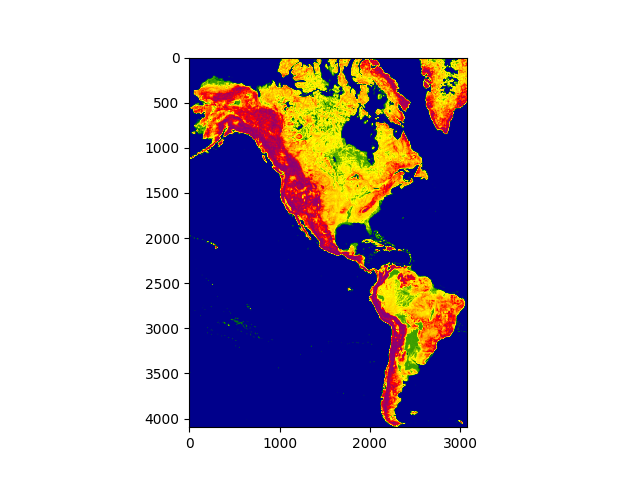

In [83]:
main()
%matplot plt